# 2024 기상청 빅데이터 콘테스트 - 과제3 (소방분야)

## 모듈 불러오기

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## 데이터 불러오기

In [2]:
df_fire = pd.read_csv('/Users/wooyeon/Desktop/기상청빅데이터콘테스트/data/fire_firefighting.csv',encoding='cp949')
df_fire = df_fire.drop(df_fire.columns[[0, 2, 5]], axis=1)
df_fire.columns = [
    'NUM', 'TM', 'district_1', 'Fire_type_1', 'Fire_type_2', 
    'Ignition_factor_category_1', 'Ignition_factor_category_2', 'casualties', 'Dead', 
    'Injury', 'Property_damage', 'location_category_1', 'location_category_2', 'location_category_3'
]
df_fire = df_fire[df_fire['district_1'] != '세종특별자치시']

df_weather = pd.read_csv('/Users/wooyeon/Desktop/기상청빅데이터콘테스트/data/fire_weather.csv',encoding='cp949')
df_weather = df_weather.drop(df_weather.columns[[0, 3, 4]], axis=1)
df_weather.columns = [
    'TM', 'district_1', 'ta_max', 'ta_min', 'ta_min_max', 'rn_day', 
    'ws_max', 'ws_ins_max', 'ws_mean', 'ws_min', 'hm_max', 'hm_mean', 'hm_min'
]
df_weather = df_weather[df_weather['district_1'] != '세종특별자치시']
numeric_cols = df_weather.select_dtypes(include=[np.number]).columns
df_weather[numeric_cols] = df_weather[numeric_cols].apply(lambda col: col.map(lambda x: np.nan if x < 0 else x))

df_weather_special = pd.read_csv('/Users/wooyeon/Desktop/기상청빅데이터콘테스트/data/fire_weather_special.csv',encoding='cp949')
df_weather_special = df_weather_special.drop(df_weather_special.columns[[0,1,4,5]], axis=1)
df_weather_special.columns = [
    'TM', 'district_1', 'REG_ID', 'WRN', 'LVL', 'CMD'
]
df_weather_special = df_weather_special[df_weather_special['district_1'] != '세종특별자치시']

In [3]:
df_fire.head()

,NUM,TM,district_1,Fire_type_1,Fire_type_2,Ignition_factor_category_1,Ignition_factor_category_2,casualties,Dead,Injury,Property_damage,location_category_1,location_category_2,location_category_3
0,1,2018-01-01 00:03:00,경기도,건축,구조물,전기적 요인,미확인단락,1,0,1,24099,주거,단독주택,상가주택(주택부분에서 화재가 발생한 경우에만 해당)
1,2,2018-01-01 00:12:00,전북특별자치도,건축,구조물,부주의,가연물 근접방치,0,0,0,2758,주거,단독주택,단독주택
2,3,2018-01-01 00:16:00,경기도,임야,NaN,부주의,담배꽁초,0,0,0,28,임야,산불,공유림
3,4,2018-01-01 00:28:00,충청남도,건축,구조물,기계적 요인,과열/ 과부하,0,0,0,1942,주거,단독주택,단독주택
4,5,2018-01-01 00:38:00,전라남도,건축,구조물,부주의,가연물 근접방치,0,0,0,1401,주거,단독주택,단독주택


In [4]:
df_weather.head()

,TM,district_1,ta_max,ta_min,ta_min_max,rn_day,ws_max,ws_ins_max,ws_mean,ws_min,hm_max,hm_mean,hm_min
0,2018-01-01,서울특별시,3.8,NaN,8.9,0.0,3.8,7.0,1.5,0.5,55.6,39.3,20.4
1,2018-01-02,서울특별시,1.8,NaN,6.1,0.0,4.9,8.5,1.8,0.2,70.6,43.6,20.1
2,2018-01-03,서울특별시,NaN,NaN,6.7,0.0,3.5,6.6,2.1,0.8,54.0,41.1,29.3
3,2018-01-04,서울특별시,NaN,NaN,8.0,0.0,3.5,5.8,1.4,0.5,56.7,44.1,31.3
4,2018-01-05,서울특별시,1.6,NaN,7.2,0.0,3.6,8.0,1.7,0.6,56.0,48.5,33.5


In [5]:
df_weather_special.head()

,TM,district_1,REG_ID,WRN,LVL,CMD
0,2018-01-01 04:00:00,경상북도,L1072100,W,2,3
1,2018-01-01 10:00:00,경상북도,L1072400,D,2,1
2,2018-01-01 10:00:00,경상북도,L1072400,D,2,1
3,2018-01-01 10:00:00,경상북도,L1072400,D,2,1
4,2018-01-01 10:00:00,부산광역시,L1080100,D,2,1


## 상관분석

### 시도에 따른 기상인자와 화재발생횟수 간의 상관분석

In [6]:
df_fire['TM'] = pd.to_datetime(df_fire['TM']).dt.date
df_weather['TM'] = pd.to_datetime(df_weather['TM']).dt.date

# 최빈값을 계산하는 함수
def mode(series):
    if not series.mode().empty:
        return series.mode().iloc[0]
    else:
        return series.iloc[0]

In [7]:
df_fire_grouped = df_fire.groupby(['TM', 'district_1']).agg({
    'NUM': 'count',
    'Fire_type_1': mode,
    'Fire_type_2': mode,
    'Ignition_factor_category_1': mode,
    'Ignition_factor_category_2': mode,
    'casualties': 'sum',
    'Dead': 'sum',
    'Injury': 'sum',
    'Property_damage': 'sum',
    'location_category_1': mode,
    'location_category_2': mode,
    'location_category_3': mode
}).reset_index()

df_weather_grouped = df_weather.groupby(['TM', 'district_1']).mean(numeric_only=True).reset_index()
df_merged = pd.merge(df_fire_grouped, df_weather_grouped, on=['TM', 'district_1'], how='left')
df_merged = pd.merge(df_fire_grouped, df_weather_grouped, on=['TM', 'district_1'], how='outer')

In [8]:
# 결측치 처리
numeric_cols = df_merged.select_dtypes(include=[np.number])
numeric_cols_interpolated = numeric_cols.interpolate(method='linear', limit_direction='both')
df_merged_interpolated = df_merged.copy()
df_merged_interpolated[numeric_cols.columns] = numeric_cols_interpolated

In [9]:
df_merged = df_merged_interpolated

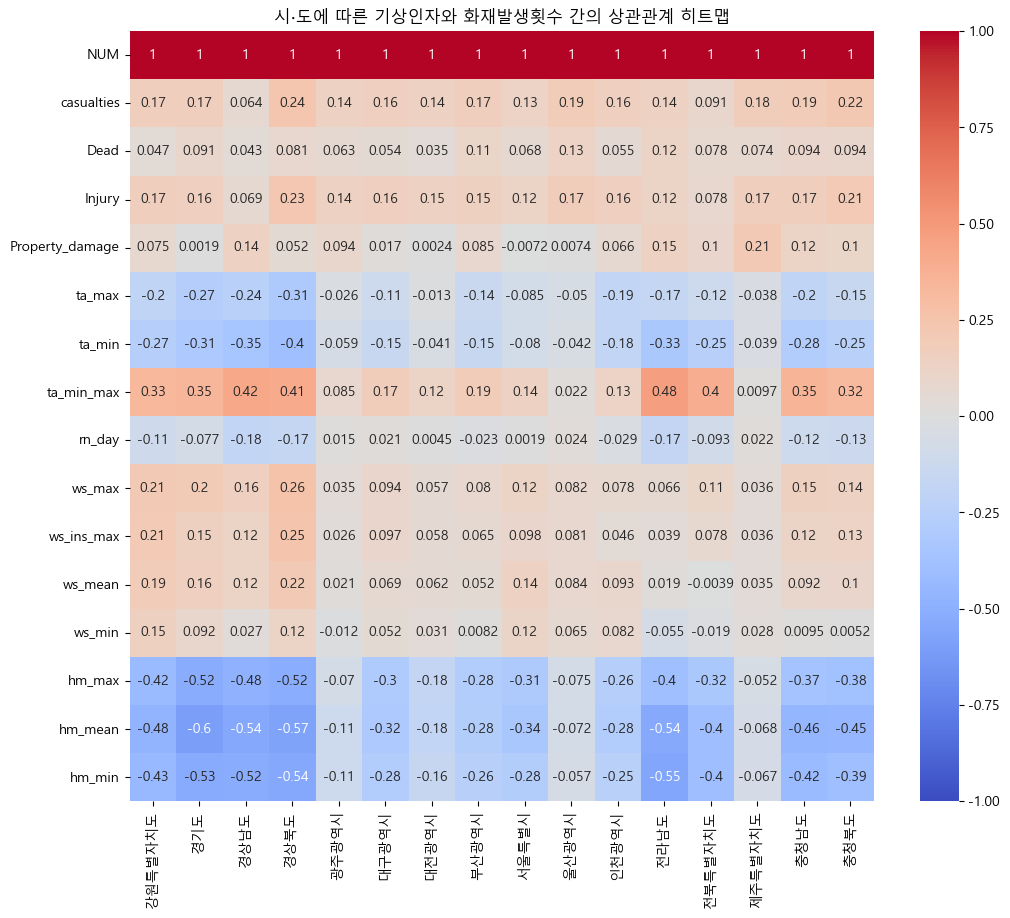

In [10]:
unique_districts = df_merged['district_1'].unique()
num_correlation_by_district_sido = {}

for district in unique_districts:
    district_data = df_merged[df_merged['district_1'] == district]
    numeric_district_data = district_data.select_dtypes(include=[float, int])
    correlation_matrix_district = numeric_district_data.corr()
    num_correlation_district = correlation_matrix_district['NUM']
    num_correlation_by_district_sido[district] = num_correlation_district

all_correlations_sido = pd.DataFrame(num_correlation_by_district_sido)

plt.figure(figsize=(12, 10))
sns.heatmap(all_correlations_sido, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('시∙도에 따른 기상인자와 화재발생횟수 간의 상관관계 히트맵')
plt.show()

### 코로나 시기와 코로나가 아닌 시기로 분류한 시∙도에 따른 기상인자와 화재발생횟수 간의 상관분석

In [11]:
df_merged['TM'] = pd.to_datetime(df_merged['TM'])
date_ranges = [
    ('2018-01-01', '2019-12-31'),
    ('2020-01-01', '2021-12-31'),
    ('2022-01-01', '2023-12-31')
]

dfs = []
for start_date, end_date in date_ranges:
    mask = (df_merged['TM'] >= start_date) & (df_merged['TM'] <= end_date)
    df_range = df_merged[mask]
    dfs.append(df_range)

df_2018_2019, df_covid, df_2022_2023 = dfs

df_non_covid = pd.concat([df_2018_2019, df_2022_2023], ignore_index=True)

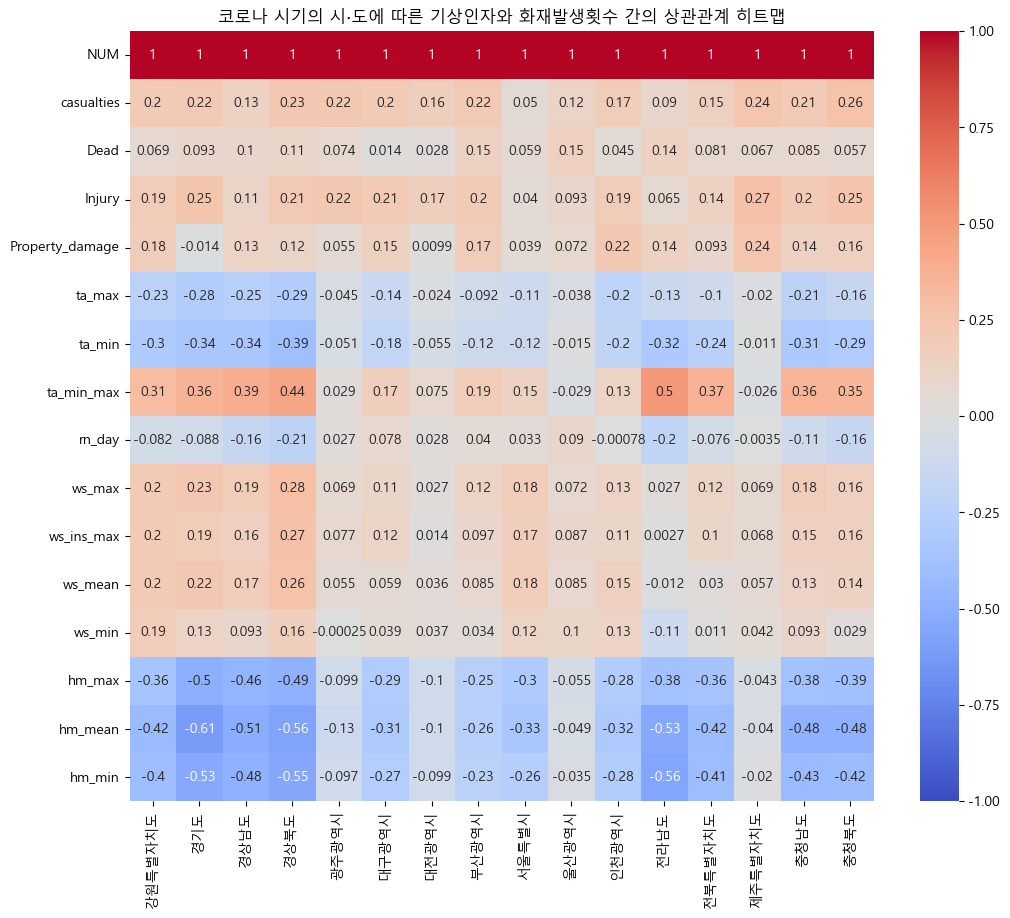

In [12]:
unique_districts = df_covid['district_1'].unique()

num_correlation_by_district = {}

for district in unique_districts:
    
    district_data = df_covid[df_covid['district_1'] == district]
    
    numeric_district_data = district_data.select_dtypes(include=[float, int])
    
    correlation_matrix_district = numeric_district_data.corr()
    
    num_correlation_district = correlation_matrix_district['NUM']
    
    num_correlation_by_district[district] = num_correlation_district

all_correlations = pd.DataFrame(num_correlation_by_district)

plt.figure(figsize=(12, 10))
sns.heatmap(all_correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('코로나 시기의 시∙도에 따른 기상인자와 화재발생횟수 간의 상관관계 히트맵')
plt.show()

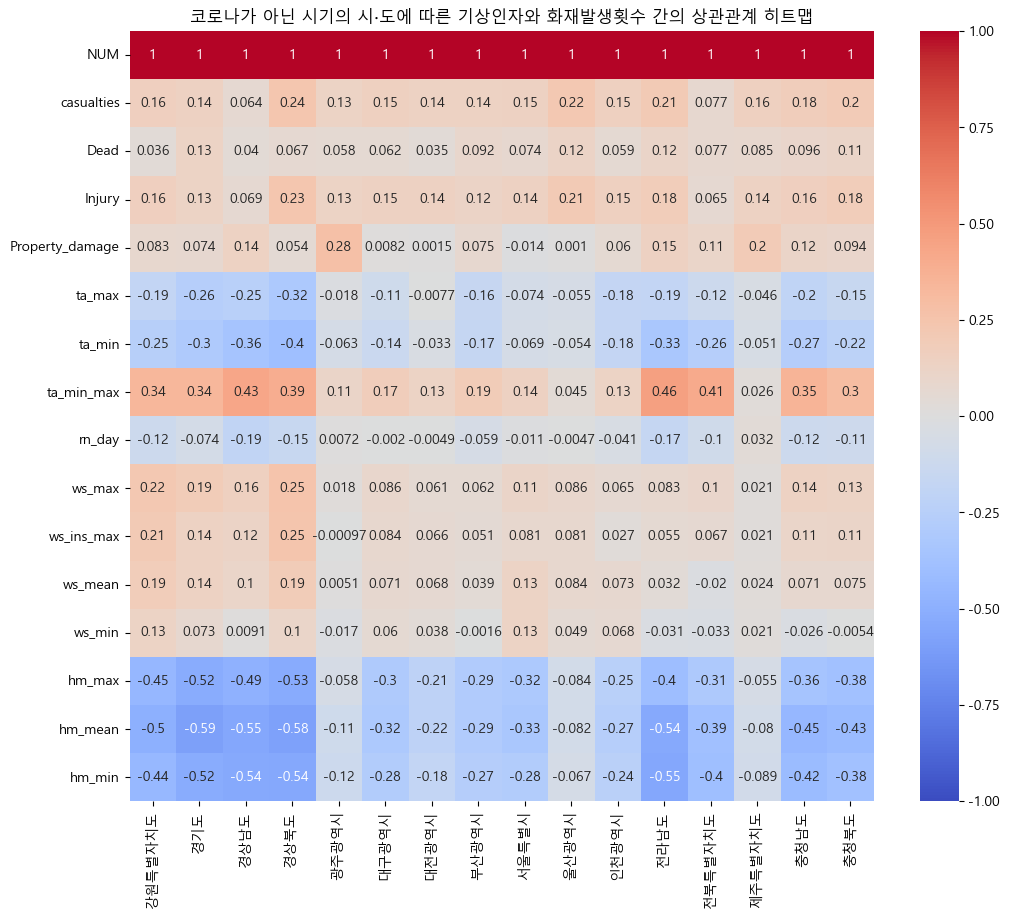

In [13]:
unique_districts = df_non_covid['district_1'].unique()
num_correlation_by_district = {}

for district in unique_districts:
    
    district_data = df_non_covid[df_non_covid['district_1'] == district]
    
    numeric_district_data = district_data.select_dtypes(include=[float, int])
    
    correlation_matrix_district = numeric_district_data.corr()
    
    num_correlation_district = correlation_matrix_district['NUM']
    
    num_correlation_by_district[district] = num_correlation_district

all_correlations = pd.DataFrame(num_correlation_by_district)

plt.figure(figsize=(12, 10))
sns.heatmap(all_correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('코로나가 아닌 시기의 시∙도에 따른 기상인자와 화재발생횟수 간의 상관관계 히트맵')
plt.show()

### 화재가 일어난 장소를 크게 분류한 항목에 따른 화재발생횟수와 그 외 인자들 간의 상관분석

In [14]:
df_fire_grouped_2 = df_fire.groupby(['TM', 'location_category_1']).agg({
    'NUM': 'count',
    'district_1': mode,
    'Fire_type_1': mode,
    'Fire_type_2': mode,
    'Ignition_factor_category_1': mode,
    'Ignition_factor_category_2': mode,
    'casualties': 'sum',
    'Dead': 'sum',
    'Injury': 'sum',
    'Property_damage': 'sum',
    'location_category_2': mode,
    'location_category_3': mode
}).reset_index()

df_weather_grouped_2 = df_weather.groupby(['TM']).mean(numeric_only=True).reset_index()

df_merged_2 = pd.merge(df_fire_grouped_2, df_weather_grouped_2, on=['TM'], how='left')

df_location = df_merged_2

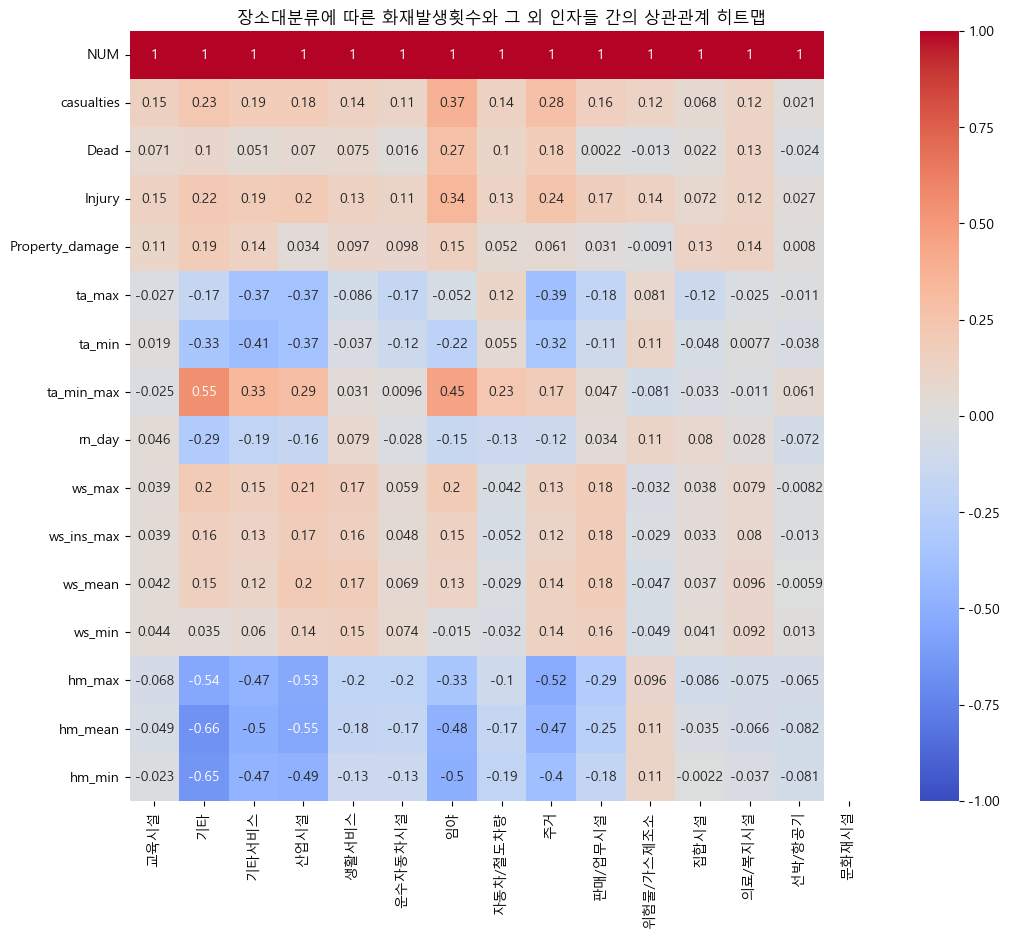

In [24]:
unique_location = df_location['location_category_1'].unique()
num_correlation_by_location = {}

for location in unique_location:
    
    location_data = df_location[df_location['location_category_1'] == location]
    
    numeric_location_data = location_data.select_dtypes(include=[float, int])
    
    correlation_matrix_location = numeric_location_data.corr()
    
    num_correlation_location = correlation_matrix_location['NUM']
    
    num_correlation_by_location[location] = num_correlation_location

all_correlations = pd.DataFrame(num_correlation_by_location)

plt.figure(figsize=(12, 10))
sns.heatmap(all_correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('장소대분류에 따른 화재발생횟수와 그 외 인자들 간의 상관관계 히트맵')
plt.savefig('/Users/wooyeon/Desktop/기상청빅데이터콘테스트/fig2/장소대분류에 따른 화재발생횟수와 그 외 인자들 간의 상관관계 히트맵.jpg')
plt.show()

### 화재가 일어난 장소를 크게 분류한 항목 중 뚜렷한 상관관계를 갖는 장소대분류를 작게 분류한 항목에 따룬 화재발생횟수와 그 외 인자들 간의 상관분석

In [16]:
df_fire_grouped_3 = df_fire.groupby(['TM', 'location_category_2']).agg({
    'NUM': 'count',
    'district_1': mode,
    'Fire_type_1': mode,
    'Fire_type_2': mode,
    'Ignition_factor_category_1': mode,
    'Ignition_factor_category_2': mode,
    'casualties': 'sum',
    'Dead': 'sum',
    'Injury': 'sum',
    'Property_damage': 'sum',
    'location_category_1': mode,
    'location_category_3': mode
}).reset_index()

df_weather_grouped_3 = df_weather.replace(-99, np.nan, inplace=True)
df_weather_grouped_3 = df_weather.groupby(['TM']).mean(numeric_only=True).reset_index()

df_merged_3 = pd.merge(df_fire_grouped_3, df_weather_grouped_3, on=['TM'], how='left')

df_location_2 = df_merged_3

values_to_remove = ['교육시설', '생활서비스', '운수자동차시설', '자동차/철도차량', '판매/업무시설', 
                    '위험물/가스제조소', '집합시설', '의료/복지시설', '선박/항공기', '문화재시설']

df_location_2_filtered = df_location_2[~df_location_2['location_category_1'].isin(values_to_remove)]

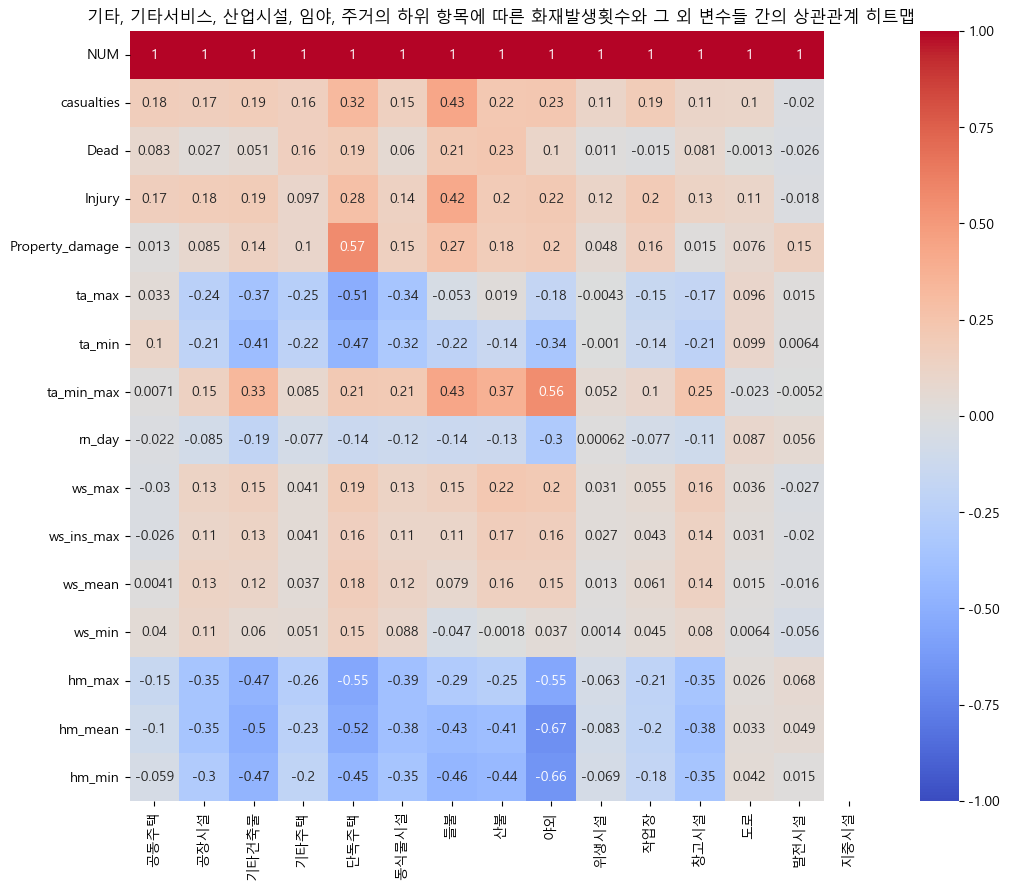

In [25]:
unique_location_2 = df_location_2_filtered['location_category_2'].unique()

num_correlation_by_location_2 = {}

for location in unique_location_2:
    
    location_data_2 = df_location_2_filtered[df_location_2_filtered['location_category_2'] == location]
    
    numeric_location_data_2 = location_data_2.select_dtypes(include=[float, int])
    
    correlation_matrix_location_2 = numeric_location_data_2.corr()
    
    num_correlation_location_2 = correlation_matrix_location_2['NUM']
    
    num_correlation_by_location_2[location] = num_correlation_location_2

all_correlations_2 = pd.DataFrame(num_correlation_by_location_2)

plt.figure(figsize=(12, 10))
sns.heatmap(all_correlations_2, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('기타, 기타서비스, 산업시설, 임야, 주거의 하위 항목에 따른 화재발생횟수와 그 외 변수들 간의 상관관계 히트맵')
plt.savefig('/Users/wooyeon/Desktop/기상청빅데이터콘테스트/fig2/기타, 기타서비스, 산업시설, 임야, 주거의 하위 항목에 따른 화재발생횟수와 그 외 변수들 간의 상관관계 히트맵.jpg')
plt.show()

### 발화요인대분류에 따른 화재발생횟수와 그 외 변수들 간의 상관분석

In [18]:
df_fire_grouped_4 = df_fire.groupby(['TM', 'Ignition_factor_category_1']).agg({
    'NUM': 'count',
    'district_1': mode,
    'Fire_type_1': mode,
    'Fire_type_2': mode,
    'Ignition_factor_category_2': mode,
    'casualties': 'sum',
    'Dead': 'sum',
    'Injury': 'sum',
    'Property_damage': 'sum',
    'location_category_1': mode,
    'location_category_2': mode,
    'location_category_3': mode
}).reset_index()

df_weather_grouped_4 = df_weather.groupby(['TM']).mean(numeric_only=True).reset_index()

df_merged_4 = pd.merge(df_fire_grouped_4, df_weather_grouped_4, on=['TM'], how='left')

values_to_remove_4 = ['기타(부주의)', '용접/ 절단/ 연마', '압착/손상에 의한 단락', '논/임야태우기', '누전/지락', '반단선', '가연물 근접방치']
df_merged_4_1 = df_merged_4[~df_merged_4['Ignition_factor_category_2'].isin(values_to_remove_4)]

df_factor = df_merged_4_1

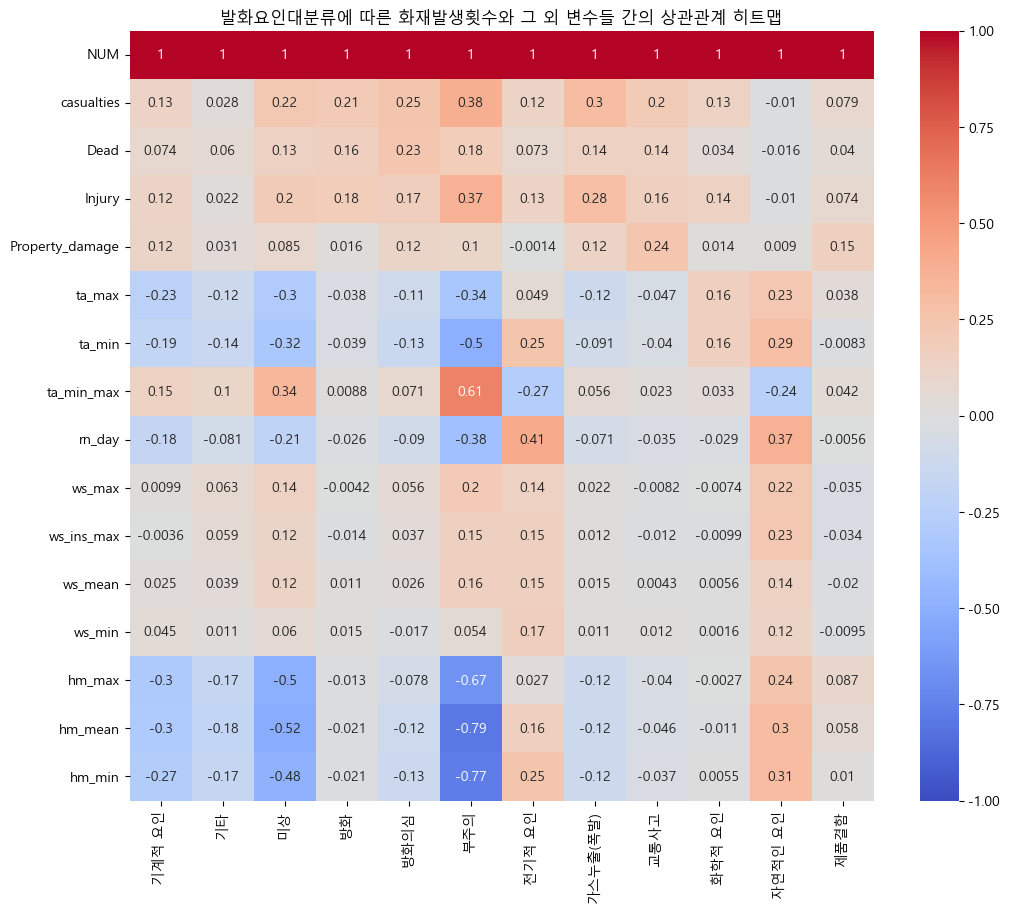

In [26]:
unique_factor = df_factor['Ignition_factor_category_1'].unique()
num_correlation_by_factor = {}

for factor in unique_factor:
    
    location_factor = df_factor[df_factor['Ignition_factor_category_1'] == factor]
    
    numeric_factor = location_factor.select_dtypes(include=[float, int])
    
    correlation_matrix_factor = numeric_factor.corr()
    
    num_correlation_factor = correlation_matrix_factor['NUM']
    
    num_correlation_by_factor[factor] = num_correlation_factor

all_correlations_factor = pd.DataFrame(num_correlation_by_factor)

plt.figure(figsize=(12, 10))
sns.heatmap(all_correlations_factor, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('발화요인대분류에 따른 화재발생횟수와 그 외 변수들 간의 상관관계 히트맵')
plt.savefig('/Users/wooyeon/Desktop/기상청빅데이터콘테스트/fig2/발화요인대분류에 따른 화재발생횟수와 그 외 변수들 간의 상관관계 히트맵.jpg')
plt.show()

### 발화요인대분류 중 뚜렷한 상관관계를 갖는 발화요인을 더 작게 분류한 항목에 따른 화재발생횟수와 그 외 변수들 간의 상관분석

In [20]:
values_to_remove_2 = ['기계적 요인', '기타', '방화', '방화의심', '가스누출(폭발)',
                      '교통사고', '화학적 요인', '제품결함']
values_to_remove_3 = ['기타(부주의)', '용접/ 절단/ 연마', '압착/손상에 의한 단락', '논/임야태우기', '누전/지락', '반단선', '가연물 근접방치']

df_factor_2_filtered = df_factor[~df_factor['Ignition_factor_category_1'].isin(values_to_remove_2)]
df_factor_3_filtered = df_factor_2_filtered[~df_factor_2_filtered['Ignition_factor_category_2'].isin(values_to_remove_3)]

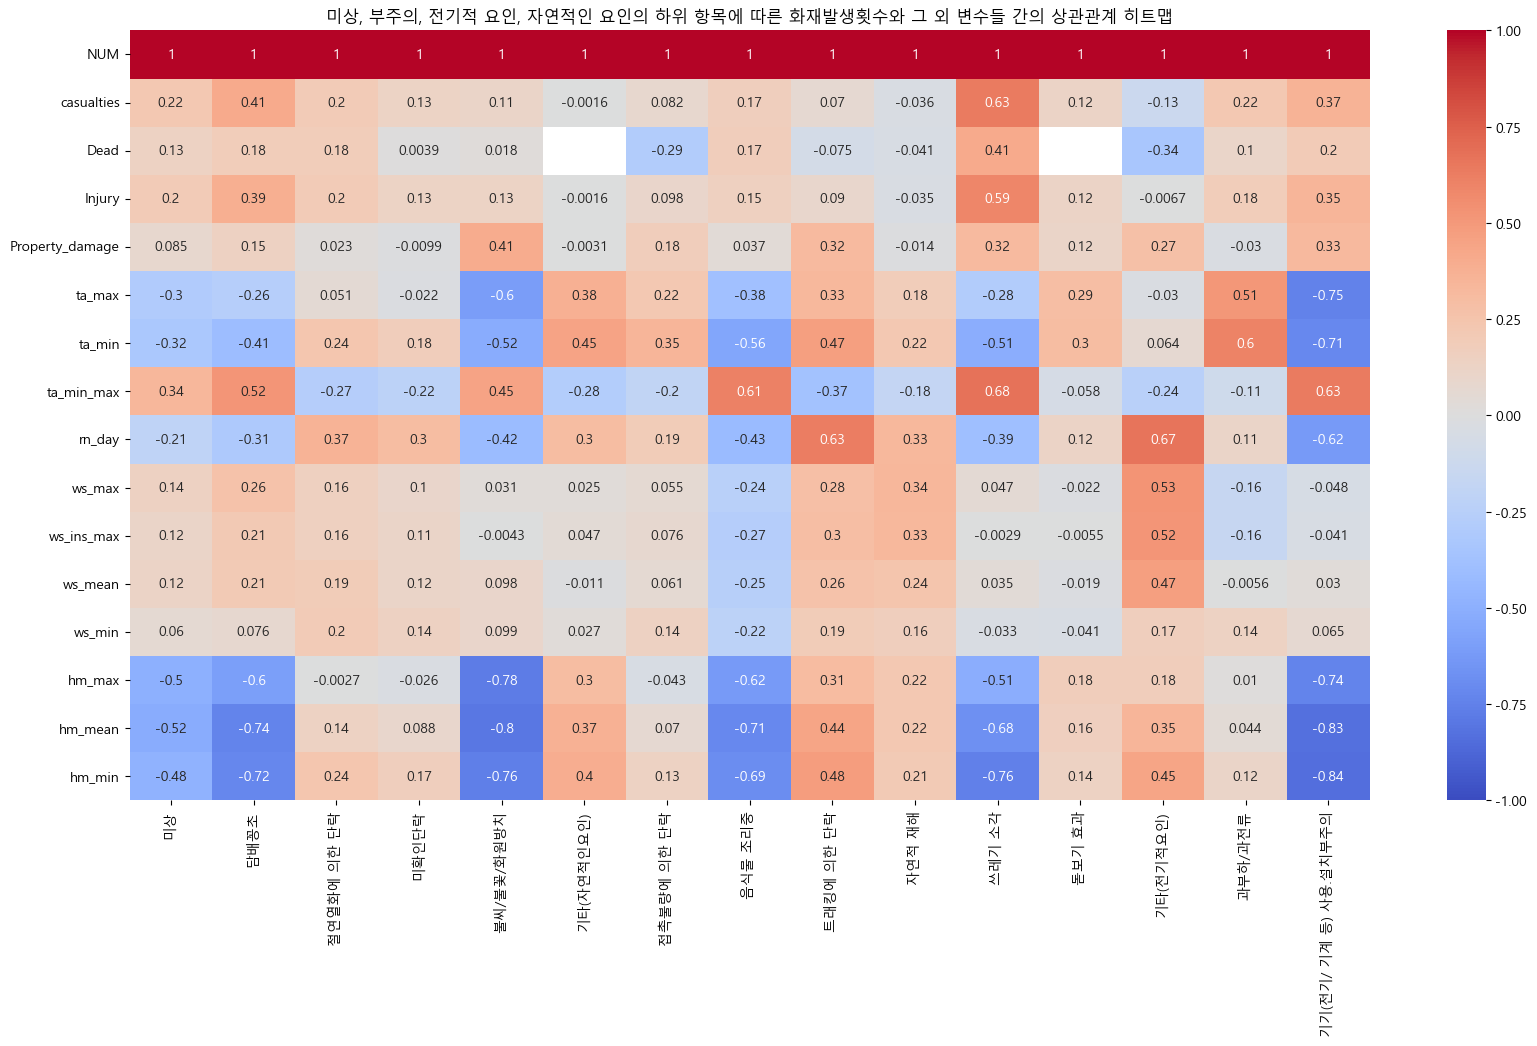

In [27]:
unique_factor_2 = df_factor_3_filtered['Ignition_factor_category_2'].unique()
num_correlation_by_factor_2 = {}

for factor in unique_factor_2:
    
    factor_data_2 = df_factor_3_filtered[df_factor_3_filtered['Ignition_factor_category_2'] == factor]
    
    numeric_factor_data_2 = factor_data_2.select_dtypes(include=[float, int])
    
    correlation_matrix_factor_2 = numeric_factor_data_2.corr()
    
    num_correlation_factor_2 = correlation_matrix_factor_2['NUM']
    
    num_correlation_by_factor_2[factor] = num_correlation_factor_2

all_correlations_factor_2 = pd.DataFrame(num_correlation_by_factor_2)

plt.figure(figsize=(20, 10))
sns.heatmap(all_correlations_factor_2, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('미상, 부주의, 전기적 요인, 자연적인 요인의 하위 항목에 따른 화재발생횟수와 그 외 변수들 간의 상관관계 히트맵')
plt.savefig('/Users/wooyeon/Desktop/기상청빅데이터콘테스트/fig2/미상, 부주의, 전기적 요인, 자연적인 요인의 하위 항목에 따른 화재발생횟수와 그 외 변수들 간의 상관관계 히트맵.jpg')
plt.show()

### 화재유형 대분류에 따른 화재발생횟수와 그 외 변수들 간의 상관분석

In [22]:
df_fire_grouped_5 = df_fire.groupby(['TM', 'Fire_type_1']).agg({
    'NUM': 'count',
    'district_1': mode,
    'Fire_type_2': mode,
    'Ignition_factor_category_1': mode,
    'Ignition_factor_category_2': mode,
    'casualties': 'sum',
    'Dead': 'sum',
    'Injury': 'sum',
    'Property_damage': 'sum',
    'location_category_1': mode,
    'location_category_2': mode,
    'location_category_3': mode
}).reset_index()

df_weather_grouped_5 = df_weather.groupby(['TM']).mean(numeric_only=True).reset_index()

df_merged_5 = pd.merge(df_fire_grouped_5, df_weather_grouped_5, on=['TM'], how='left')

df_type_1 = df_merged_5

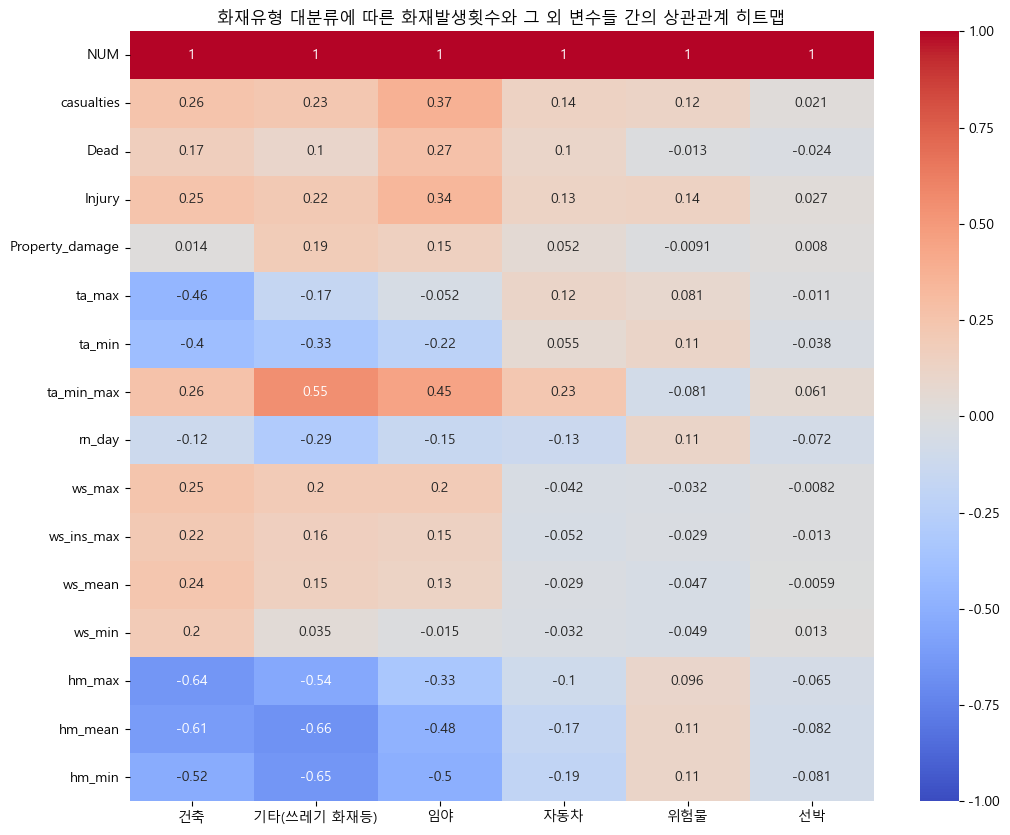

In [28]:
unique_type_1 = df_type_1['Fire_type_1'].unique()
num_correlation_by_type_1 = {}

for type_1 in unique_type_1:
    
    location_type_1 = df_type_1[df_type_1['Fire_type_1'] == type_1]
    
    numeric_type_1 = location_type_1.select_dtypes(include=[float, int])
    
    correlation_matrix_type_1 = numeric_type_1.corr()
    
    num_correlation_type_1 = correlation_matrix_type_1['NUM']
    
    num_correlation_by_type_1[type_1] = num_correlation_type_1

all_correlations_type_1 = pd.DataFrame(num_correlation_by_type_1)

plt.figure(figsize=(12, 10))
sns.heatmap(all_correlations_type_1, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('화재유형 대분류에 따른 화재발생횟수와 그 외 변수들 간의 상관관계 히트맵')
plt.savefig('/Users/wooyeon/Desktop/기상청빅데이터콘테스트/fig2/화재유형 대분류에 따른 화재발생횟수와 그 외 변수들 간의 상관관계 히트맵.jpg')
plt.show()